In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Dungeon Mayhem Card Game

Dungeon Mayhem is a multiplayer card game. A player's turn consists of drawing a card and then playing a card where each card has symbols in the top for the actions to be done. There are 4 basic actions: deal damage, heal, draw another card, and play another card. A card will have up to three actions in any combination, for example: draw a card twice, then deal one damage. In a game, players start with 10 health and take turns playing cards until only one player remains. I decided to simulate a simple version of this game where players have infinite cards in hand so there is no drawing and I don't have to worry about players running out of cards they can play. I chose this since if a player runs out of cards while they can still play, then must draw and keep playing and thus a hand only serves to give players strategic options. For the cards, they can only have one type of symbol and the number of instances of that symbol will be chosen randomly. So first, I will define a "deck" which gives the probabilities for getting different types of symbols and the probability for the number of symbols. The deck class will also handle player health and card playing.

In [2]:
class Deck:
    def __init__(self, probs_heal, probs_attack, probs_extra):
        
        #define initial health
        self.health = 10
        
        #Gives a normalized probability for the three actions
        #In order: heal, attack, play an extra card
        actions = np.array([probs_heal[0], probs_attack[0], probs_extra[0]])
        self.actions_norm = actions/np.sum(actions) 
        
        #When a player heals, they can heal 1, 2, or 3 times
        #This gives normalized probabilities for these
        heals = np.array(probs_heal[1:])
        self.heal_act_norm = heals/np.sum(heals)
        
        #When a player attacks, they can attack 1, 2, or 3 times
        #This gives normalized probabilities for these
        attacks = np.array(probs_attack[1:])
        self.attack_act_norm = attacks/np.sum(attacks)
        
        #When a player plays again, they can play either 1 or 2 extra cards
        #This gives normalized probabilities for these
        extra = np.array(probs_extra[1:])
        self.extra_act_norm = extra/np.sum(extra)
    
    def set_opponent(self, opponent):
        #Set the opponent you are playing against
        self.opponent = opponent
    
    def heal(self):
        #Gain back 1 health to a max of 10
        if self.health < 10:
            self.health += 1
    
    def damage(self):
        #Lose one health
        if self.health > 0:
            self.health -= 1
        
    def reset(self):
        #Resets health to 10 and opponent to None for new games
        self.health = 10
        self.opponent = None
        
    def play(self):
        #Handles when a player plays cards
        
        #chose action based of probability then based off action, chose how many times
        choice = np.random.choice([1,2,3], p=self.actions_norm)
                                                                    
        if choice == 1:
            times = np.random.choice([i+1 for i in range(len(self.heal_act_norm))], p=self.heal_act_norm) 
            for _ in range(times):
                self.heal()
        elif choice == 2:
            times = np.random.choice([i+1 for i in range(len(self.attack_act_norm))], p=self.attack_act_norm)
            for _ in range(times):
                self.opponent.damage()
        else:
            times = np.random.choice([i+1 for i in range(len(self.extra_act_norm))], p=self.extra_act_norm)
            for _ in range(times):
                self.play()

The way a deck is specified is with 3 arrays which relate to healing, attacking, playing again respectively. For each of these, the 0th position defines the relative probabilities of each action. For the rest of the array, the index is the amount of times the action happens, and the value give the relative probabilities. I coded this way since these values are supposed to be taken from sampling the actual decks in the game. So the 0th index is the number of cards with this symbol divided by the total number of cards in the deck.

In [3]:
#I will define two decks, the first one was created to attack most often, for the second I tried to make balanced values
player1 = Deck([.2, .7, .2, .1], [.4, .4, .4, .2], [.1, .8, .2]) 

player2 = Deck([.3, .6, .3, .1], [.25, .7, .2, .1], [.15, .5, .5])


def game(player1, player2, track_health=False, health_arrays=()):
    #This is a function to run a game between two players
    
    #First reset the two players health and set each other as opponents
    player1.reset()
    player2.reset()
    player1.set_opponent(player2)
    player2.set_opponent(player1)
    
    #Set turn count to zero
    turn = 0
    
    #Now to actually run the game
    while player1.health > 0 and player2.health > 0:
        #Increment the turn count then have players go in order
        turn += 1
        player1.play()
        
        if player2.health == 0:
            if track_health:
                health_arrays[0].append(player1.health)
                health_arrays[1].append(player2.health)
            break
            
        player2.play()
        
        if track_health:
            health_arrays[0].append(player1.health)
            health_arrays[1].append(player2.health)
    
    if player1.health == 0:
        winner = 2
    else:
        winner = 1
        
    return turn, winner

As a test, let's plot players health over one game.

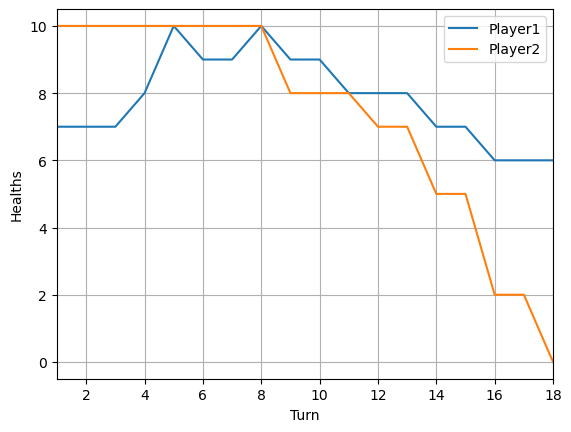

In [4]:
player1_health = []
player2_health = []

turns, winner = game(player1, player2, True, (player1_health, player2_health))

fig1 = plt.plot(np.arange(1, turns+1), player1_health, label="Player1")
plt.plot(np.arange(1,turns+1), player2_health, label="Player2")
plt.xlabel("Turn")
plt.ylabel("Healths")
plt.xlim(1, turns)
plt.legend()
plt.grid()
plt.show()

If you run this multiple times, you can see that the healths are very different between games. This variation comes from the fact that all plays are made randomly. To get an actual understanding of how the two decks interact, it is much better to look at outcomes over multiple games.

Player1 won 72.13% of the time


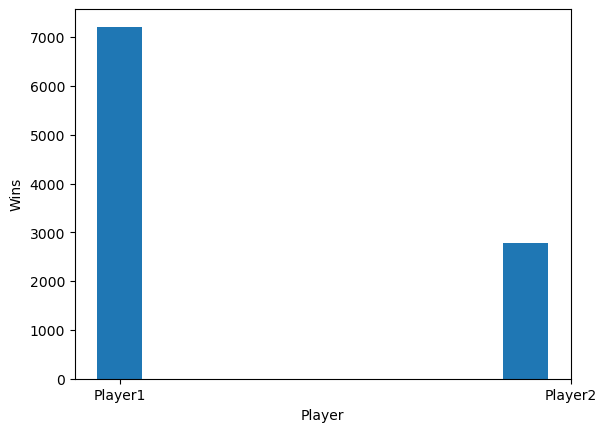

In [5]:
#I defined arrays so I can look at win rates and the number of turns
turns = []
winners = []
number_of_games = 10000

for i in range(number_of_games):
    a,b = game(player1, player2)
    turns.append(a)
    winners.append(b)
    
player1_turns = [turns[i] for i in range(len(winners)) if winners[i] == 1]
player2_turns = [turns[i] for i in range(len(winners)) if winners[i] == 2]

#Create a histogram of how often players won
fig2 = plt.hist([f'Player{i}' for i in winners], align='left')
plt.xlabel('Player')
plt.ylabel('Wins')
plt.plot()

print(f'Player1 won {len(player1_turns)/number_of_games*100:.2f}% of the time')

In total, the average number of turns is: 19.78
However, when player one wins, the average turns is: 19.18
When player two wins, the average becomes to: 21.33


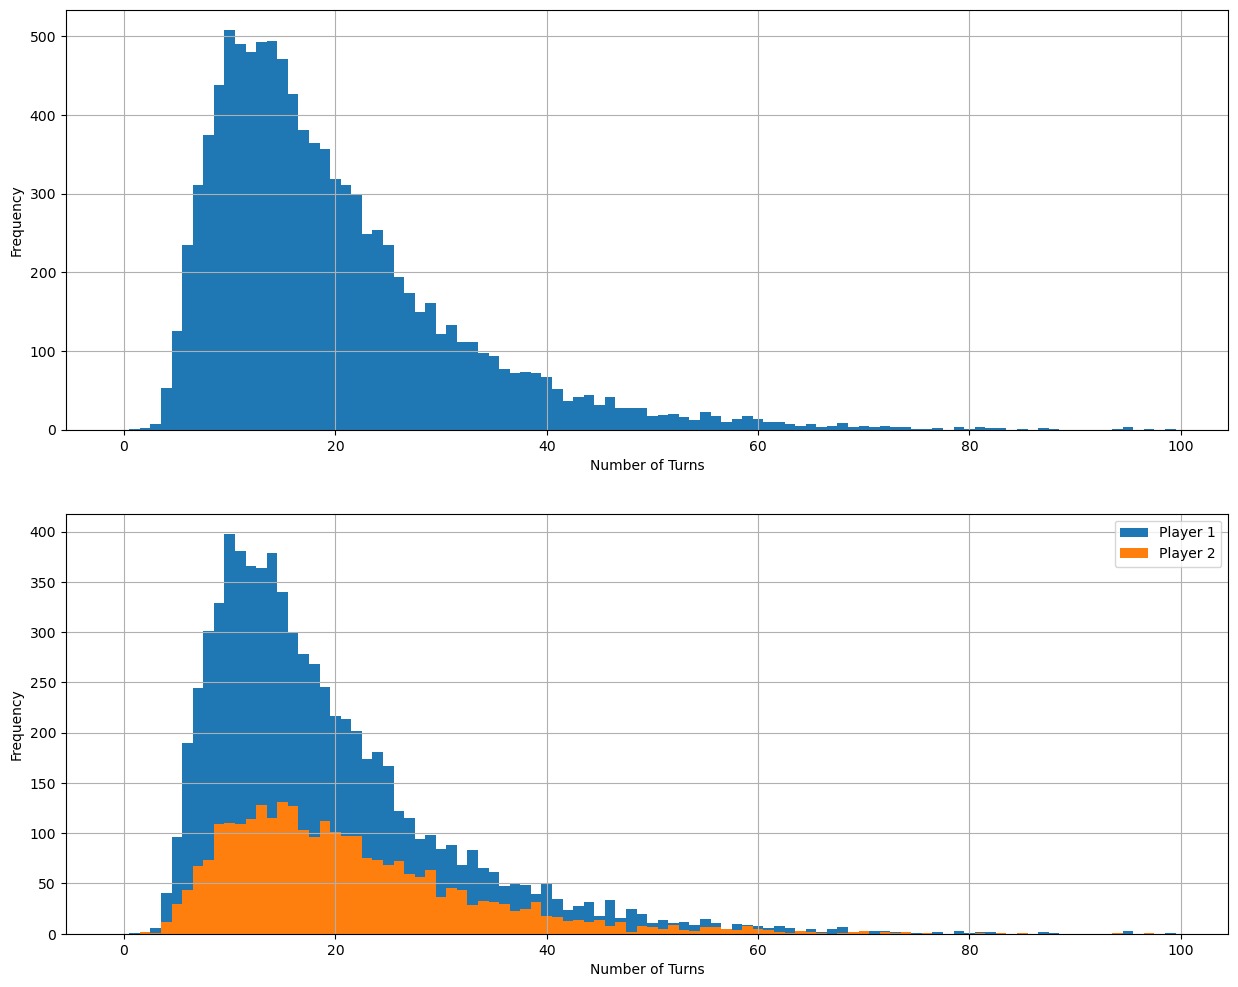

In [6]:
#Create two histograms, the first is the total number of turns.
#The second is number of turns dependent on which player won the game
fig,ax = plt.subplots(2,1, figsize=(15,12))
ax[0].grid(True)
ax[1].grid(True)
ax[0].hist(turns, bins=100, range=(0,100),  align='left')
ax[1].hist(player1_turns, bins=100, range=(0,100),  align='left', label="Player 1")
ax[1].hist(player2_turns, bins=100, range=(0,100),  align='left', label="Player 2")
ax[1].legend()
ax[0].set_xlabel("Number of Turns")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Number of Turns")
ax[1].set_ylabel("Frequency")
plt.plot()

print(f'In total, the average number of turns is: {np.average(turns):.2f}')
print(f'However, when player one wins, the average turns is: {np.average(player1_turns):.2f}')
print(f'When player two wins, the average becomes to: {np.average(player2_turns):.2f}')

Now you can define a deck to see if it can beat the winner of the last game

In [7]:
#All the probabilities are normalized so you don't have to enter them to add to one
#The probability_of_x variables will be normalized together and then the one, two, and three values for each action will be normalized

probability_of_healing = 1    #Relative probability of taking a heal action
heal_one = 1
heal_two = 1
heal_three = 1

probability_of_attacking = 1    #Relative probability of taking an attack action
attack_one = 1
attack_two = 1
attack_three = 1

probability_of_extra_turn = 1    #Relative probability of taking an extra action
one_extra = 1
two_extra = 1

player3 = Deck([probability_of_healing, heal_one, heal_two, heal_three], [probability_of_attacking, attack_one, attack_two, attack_three], [probability_of_extra_turn, one_extra, two_extra])

In [8]:
winners2 = []
number_of_games2 = 1000

for i in range(number_of_games2):
    a,b = game(player1, player3)
    winners2.append(b)

wins = [i for i in winners2 if i == 2]

print(f"Your deck won {len(wins)} times out of {number_of_games2} games")

Your deck won 901 times out of 1000 games
